### Lingering questions
- confusion matrix intuition
- meaning of precision / recall performance measures
  - **Precision**: out of all positive predictions, how many were accurate
      - you can pretty much create a classifier with any precision you want. just set the threshold high enough. but your recall will suffer.
      - True positives / (True positives + false positives)
  - **Recall**: out of all instances that were supposed to be labeled positive, how many were?
      - True positives / (True positives + false negatives)

Figure 3-3. Decision threshold and precision/recall tradeoff
![Figure 3-3. Decision threshold and precision/recall tradeoff](images/3-3.png)

In [2]:
import numpy as np
import os
import warnings

np.random.seed(42)
warnings.filterwarnings(action="ignore", category=FutureWarning)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

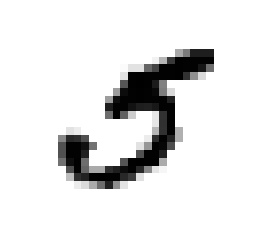

In [7]:
sample_5 = X[36000]
sample_5_image = np.reshape(sample_5, (28, 28))
plt.imshow(sample_5_image, cmap=matplotlib.cm.binary)
plt.axis('off')
plt.show()

In [8]:
y[36000]

5.0

In [9]:
# test and train sets alreaady split by sklearn
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# shuffle to make sure that when we do cross validation, each fold contains all the numbers
# np.random.permutation takes an int (treated as a range from 0~) or a list and shuffles it
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [10]:
# trying to just identify a single digit for now
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [11]:
from sklearn.linear_model import SGDClassifier

# 'stochastic' means 'random determined'
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([sample_5])

array([ True])

# Performance Measures

In [13]:
# cross validation is one way to measure the accuracy of a model
# K-fold CV does the following
# 1. splits the training set into a given number (K) of folds
# 2. trains a model on the training fold data, and makes predictions on the fold test data
# 3. (?)evaluates those predictions on each fold using a model trained on the other folds
from sklearn.model_selection import cross_val_score

# the 'accuracy' scoring is the ratio of correct predictions
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
# Because only 10% of the images are 5s, we can get 90% accuracy just by guessing 'not 5' every time.
# Accuracy scoring is generally not the preferred way to measure classifier performance.
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

In [16]:
# Custom implementation of cross validation with accuracy scoring
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X=X_train_folds, y=y_train_folds)
    y_pred = clone_clf.predict(X=X_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


# Confusion Matrix

In [17]:
# to compute the confusion matrix, you need a set of predictions to compare to the target values
# cross_val_predict returns the predictions (not the scores) from the cross validation
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [18]:
from sklearn.metrics import confusion_matrix

# a row represents an actual class
# a column represents a predicted class
# 1307 wrongly classified as 5s
# 1077 wrongly classified as non-5s
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

In [19]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [20]:
# another metric is the accuracy of the positive predictions (call the "precision classifier")
# it is used alongside "recall" which is the ratio of positive instances that are correctly detected by the classifier
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(precision) # 4344 / (4344 + 1307)
print(recall)    # 4344 / (4344 + 1077)

0.7687135020350381
0.801328168234643


The harmonic mean of precision and recall gives you the F1 score, which is commonly used to combine precision and recall.

$
F_1=\dfrac{2}{ \dfrac{1}{precision} + \dfrac{1}{recall} }
$

In [21]:
from sklearn.metrics import f1_score

# computing f1_score with sklearn
print(f1_score(y_train_5, y_train_pred))

# is the same as the following
print(2 * (precision * recall) / (precision + recall))

0.7846820809248555
0.7846820809248555


In [22]:
# try adjusting the threshold ourselves
# decision_function returns a score for each instance
# and lets us make a prediction with any threshold we want
# based on that score
y_scores = sgd_clf.decision_function([sample_5])
y_scores

array([161855.74572176])

In [23]:
threshold = 0
y_sample_5_pred = (y_scores > threshold)
y_sample_5_pred

array([ True])

In [24]:
# raising the threshold decreases recall
# when the threshold was lower, the 5 was predicted correctly
# but when we raised the threshold, the 5 was missed
threshold = 200000
y_sample_5_pred = (y_scores > threshold)
y_sample_5_pred

array([False])

In [25]:
# here is how we can get all the decision function scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

In [26]:
from sklearn.metrics import precision_recall_curve

# this will give us what we need to visualize the 
# relationship between precision, recall & threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

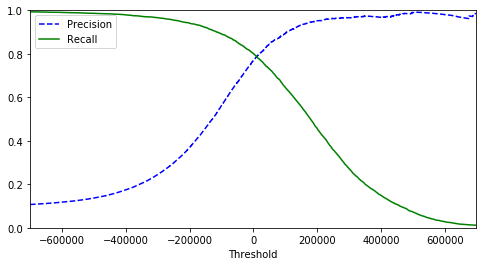

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plt.xlim([-700000, 700000])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [28]:
# let's say we want to aim for 90% precision
# if you look at the graph above, it looks like we should set our threshold
# at around 70,000
y_train_pred_90 = (y_scores > 70000)

In [29]:
precision_score(y_true=y_train_5, y_pred=y_train_pred_90)

0.8659205116491548

In [30]:
recall_score(y_true=y_train_5, y_pred=y_train_pred_90)

0.6993174691016417

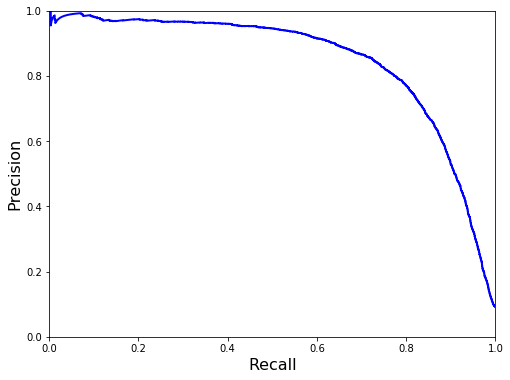

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# The ROC Curve

In [34]:
# receiver operating characteristic (ROC) curve is common tool used with binary classifiers
# it plots the 'true positive rate' (recall) against the 'false positive rate'
# FPR = negative instances that are incorrectly classified as positive (equal to 1 - TNR)
# TNR (also called 'specificity') = ratio of negative instances correctly classified as negative
# so, ROC plots 'sensitivity (ie Recall)' versus (1 - specificity)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
fpr, tpr, thresholds

(array([0.00000000e+00, 0.00000000e+00, 1.83220653e-05, ...,
        9.94466736e-01, 9.94466736e-01, 1.00000000e+00]),
 array([1.84467810e-04, 3.87382402e-03, 3.87382402e-03, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([ 1002862.09359785,   788024.40783823,   786459.71073829, ...,
        -1612415.64410228, -1613405.71147769, -2922518.84137436]))

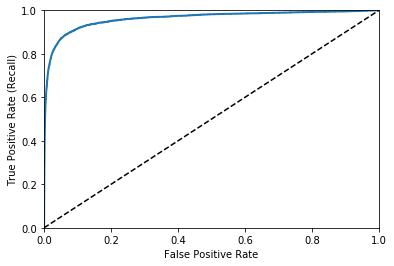

In [43]:
# you should use PR curve when the positive class is rare, 
# or you care more about the false positives than the false negatives;
# otherwise, use the ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # this line shows what an ROC curve of a completely random ROC classifier would produce
    # good classifiers stay as far away from this line as possible (to the top left)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')

plot_roc_curve(fpr, tpr)
plt.show()

In [44]:
# AUC stands for 'area under the curve'
# a perfect classifier score would be 1
# a purely random classifier score would be 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9624496555967155